In [67]:
import math
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import math as math

mpl.rcParams['font.family'] = 'serif'

In [68]:
#
# Analyzing Returns from Geometric Brownian Motion
#
# Helper Function
#   
def dN(x, mu, sigma):   
    ''' Probability density function of a normal random variable x'''
    #mu: float 
    #   expect value
    #sigma: float
    #   standard deviation
    z = (x - mu) / sigma
    pdf = np.exp(-0.5 * z ** 2) / math.sqrt(2 * math.pi * sigma ** 2)
    return pdf

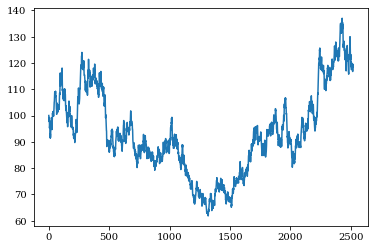

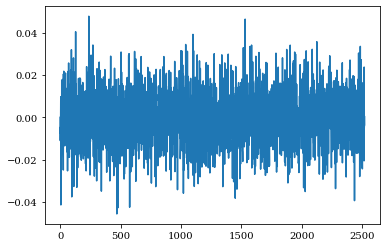

(array([[100.        ],
        [ 98.9042953 ],
        [ 98.4448669 ],
        ...,
        [118.9787268 ],
        [119.05144838],
        [118.62441217]]),
 array([[ 0.        ],
        [-0.01101752],
        [-0.004656  ],
        ...,
        [-0.00475532],
        [ 0.00061103],
        [-0.00359344]]))

In [72]:
def simulate_gbm():
# model parameters
    S0 = 100.0 # initial index level
    T = 10.0 # time horizon
    r = 0.05 # risk-less short rate
    vol = 0.2 # instantaneous volatility
    # simulation parameters
    np.random.seed(250000) #using a seed so I can get the same simulation
    M = 252 * 10 # time steps
    I = 1 # index level paths
    dt = 1 / 252. # fixed for simplicity
    df = math.exp(-r * dt) # discount factor
    # stock price paths
    rand = np.random.standard_normal((M, I)) # random numbers
    S = np.zeros_like(rand) # stock matrix
    S[0] = S0 # initial values
    V = np.zeros_like(rand)
    V[0] = 0
    for t in range(1, M): # stock price paths
        #discrete verions given the the difference equation for times t
        S[t] = S[t - 1] * np.exp((r - vol ** 2 / 2) * dt + vol * rand[t] * math.sqrt(dt))
        gbm = pd.DataFrame()
        V[t] = math.log(S[t]) - math.log(S[t-1])
    
    plt.plot(S)
    plt.show()
    plt.plot(V)
    plt.show()

    return S,V

simulate_gbm()


In [51]:
# Return Sample Statistics and Normality Tests
def print_statistics(data):
    print("RETURN SAMPLE STATISTICS")
    print("---------------------------------------------")
    print("Mean of Daily Log Returns %9.6f" % np.mean(data['returns']))
    print("Std of Daily Log Returns %9.6f" % np.std(data['returns']))
    print("Mean of Annua. Log Returns %9.6f" % (np.mean(data['returns']) * 252))
    print("Std of Annua. Log Returns %9.6f" %  (np.std(data['returns']) * math.sqrt(252)))
    print("---------------------------------------------")
    print("Skew of Sample Log Returns %9.6f" % scs.skew(data['returns']))
    print("---------------------------------------------")

In [52]:
#
# Graphical Output
#
# daily quotes and log returns
def quotes_returns(data):
    ''' Plots quotes and returns. '''
    plt.figure(figsize=(9, 6))
    plt.subplot(211)
    data['index'].plot()
    plt.ylabel('daily quotes')
    plt.grid(True)
    plt.axis('tight')
    plt.subplot(212)
    data['returns'].plot()
    plt.ylabel('daily log returns')
    plt.grid(True)
    plt.axis('tight')
    
# histogram of annualized daily log returns
def return_histogram(data):
    ''' Plots a histogram of the returns. '''
    plt.figure(figsize=(9, 5))
    x = np.linspace(min(data['returns']), max(data['returns']), 100)
    plt.hist(np.array(data['returns']), bins=50, normed=True)
    y = dN(x, np.mean(data['returns']), np.std(data['returns']))
    plt.plot(x, y, linewidth=2)
    plt.xlabel('log returns')
    plt.ylabel('frequency/probability')
    lt.grid(True)

# Q-Q plot of annualized daily log returns
def return_qqplot(data):
    ''' Generates a Q-Q plot of the returns.'''
    plt.figure(figsize=(9, 5))
    sm.qqplot(data['returns'], line='s')
    plt.grid(True)
    plt.xlabel('theoretical quantiles')
    plt.ylabel('sample quantiles')


In [53]:
# realized volatility
def realized_volatility(data):
    ''' Plots the realized volatility. '''
    plt.figure(figsize=(9, 5))
    data['rea_vol'].plot()
    plt.ylabel('realized volatility')
    plt.grid(True)


# mean return, volatility and correlation (252 days moving = 1 year)
def rolling_statistics(data):
    ''' Calculates and plots rolling statistics (mean, std, correlation). '''
    plt.figure(figsize=(11, 8))
    plt.subplot(311)
    mr = pd.rolling_mean(data['returns'], 252) * 252
    mr.plot()
    plt.grid(True)
    plt.ylabel('returns (252d)')
    plt.axhline(mr.mean(), color='r', ls='dashed', lw=1.5)
    plt.subplot(312)
    vo = pd.rolling_std(data['returns'], 252) * math.sqrt(252)
    vo.plot()
    plt.grid(True)
    plt.ylabel('volatility (252d)')
    plt.axhline(vo.mean(), color='r', ls='dashed', lw=1.5)
    vx = plt.axis()
    plt.subplot(313)
    co = pd.rolling_corr(mr, vo, 252)
    co.plot()
    plt.grid(True)
    plt.ylabel('correlation (252d)')
    cx = plt.axis()
    plt.axis([vx[0], vx[1], cx[2], cx[3]])
    plt.axhline(co.mean(), color='r', ls='dashed', lw=1.5)

In [54]:
import pandas.io.data as web
from GBM_returns import *
# Read Data for DAX from the Web
def read_dax_data():
    ''' Reads historical DAX data from Yahoo! Finance, calculates log returns,
    realized variance and volatility.'''
    DAX = web.DataReader('ˆGDAXI', data_source='yahoo',
    start='30-09-2004', end='30-09-2014')
    DAX.rename(columns={'Adj Close' : 'index'}, inplace=True)
    DAX['returns'] = np.log(DAX['index'] / DAX['index'].shift(1))
    DAX['rea_var'] = 252 * np.cumsum(DAX['returns'] ** 2) / np.arange(len(DAX))
    DAX['rea_vol'] = np.sqrt(DAX['rea_var'])
    DAX = DAX.dropna()
    return DAX

def count_jumps(data, value):
    ''' Counts the number of return jumps as defined in size by value. '''
    jumps = np.sum(np.abs(data['returns']) > value)
    return jumps

ModuleNotFoundError: No module named 'pandas.io.data'